In [136]:
%pylab inline
import numpy as np
from scipy.spatial.distance import cdist
import sys
sys.path.append("../")
import sgd
reload(sgd)
import theano
import theano.tensor as T
import topogen
import sklearn.datasets
import util
import cPickle as pickle
import exputil
import time
import pandas as pd
import seaborn as sns
import sklearn.metrics
sns.set_style('whitegrid')
basename = 'synfire_recovery'

Populating the interactive namespace from numpy and matplotlib


xtrue.shape= (80, 2)
(80, 80)
(80, 80)


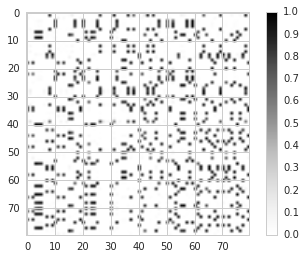

In [149]:
import synthetic
total_nodes = 100


def synfire_latent_space(layers, cells_per_layer, 
                         D=2, gauss_size=0.5, loss_scale=0.5, 
                        latent_sep = 1.0, spatial_jitter = 0.1):
    
    N = layers * cells_per_layer
    xtrue = np.zeros((N, D))
    xtrue[:, 0] = np.arange(N) // cells_per_layer
    xtrue[:, 1] = xtrue[:, 0]
    xtrue *= latent_sep
    xtrue = np.random.permutation(xtrue)
    lossobj = losses.Logistic(loss_scale)

    kern_func = kernels.gauss_os(gauss_size, bindtheta=np.ones(D)*latent_sep)
    
    kern_f = exputil.make_kern_f(kern_func)
    
    xtrue += np.random.normal(0, spatial_jitter, (N, D))
    
    print "xtrue.shape=", xtrue.shape
    kern_val = kern_f(xtrue, None)
    pylab.imshow(kern_val)
    pylab.colorbar()
    print kern_val.shape
    obs = lossobj.obs_forward(kern_val)
    print obs.shape
    return synthetic.latent_space_to_graph(obs, xtrue)

G = synfire_latent_space(8, 10, latent_sep=1.0, loss_scale=0.5)



obs = synthetic.get_adj_mat(G)
neurondf = synthetic.get_nodes_to_df(G)

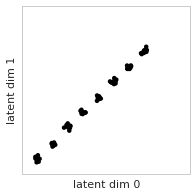

In [153]:
pos = np.vstack(neurondf['pos'])
pylab.figure(figsize=(3,3))
pylab.scatter(pos[:, 0], pos[:, 1], c='k', edgecolor='none')
pylab.grid(False)
pylab.xticks([])
pylab.yticks([])
pylab.xlim(-1, 10)
pylab.ylim(-1, 10)
pylab.xlabel("latent dim 0")
pylab.ylabel("latent dim 1")

#pylab.ylim(-1.2, 1.2)
pylab.savefig("%s.truelatent.pdf"% basename)

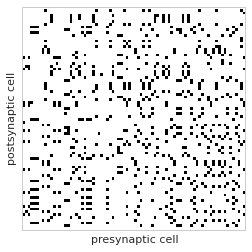

In [154]:

pylab.imshow(obs, interpolation='nearest')
pylab.grid(False)
pylab.grid(False)
pylab.xticks([])
pylab.yticks([])
pylab.xlabel("presynaptic cell")
pylab.ylabel("postsynaptic cell")
pylab.savefig("%s.rawconn.pdf"% basename)

(900, 900)


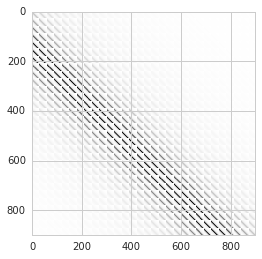

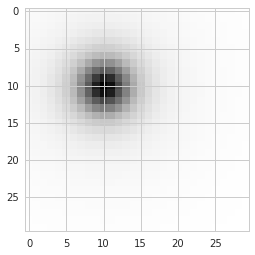

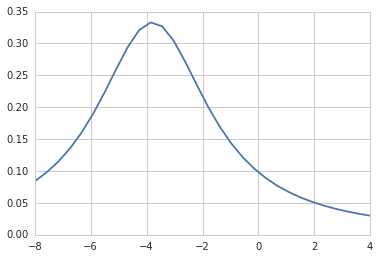

In [140]:
import kernels
reload(kernels)
reload(exputil)


g1 = kernels.rational_quad_os(1.0, 1.0, bindtheta=np.ones(3)*2)
                   
                    
kern_func = g1

kern_f = exputil.make_kern_f(kern_func)
N = 30
x = np.linspace(-8, 4, N)
xv, yv = np.meshgrid(x, x)
points = np.array([xv.flatten(), yv.flatten()]).T
#points = np.meshgrid()
r  = kern_f(points, [0.5, 0.5])
print r.shape
pylab.imshow(r, interpolation='nearest')
pylab.figure()
pylab.imshow(r[N**2/2 + N/2].reshape((N, N)), interpolation='nearest')
pylab.figure()
pylab.plot(x, r[N**2/2 + N/2].reshape((N, N))[N/2])

In [141]:
reload(sgd)
import losses
reload(losses)

N = len(obs)
D = 2
offset = 2

g1 = kernels.rational_quad_os(1.0, 1.0, bindtheta=np.ones(D)*offset)
                   
                    
kern_func = g1
lossobj = losses.Logistic(0.5)


obs_valid = np.ones_like(obs) > 0



In [142]:
### 
reload(sgd)
ITERS = 100000

xinit = np.random.normal(0, 2.0, (N, D))
U, s, V = np.linalg.svd(obs)
print U.shape, obs.shape, D
xinit = U[:, :D] *20
print xinit.shape
theta_init = np.zeros(D) 

t1 = time.time()
#res = sgd.run_sgd_full(kern_func, lossobj.cost(), 
#                   xinit, theta_init, obs, obs_valid, alpha=0.1,
#                   iters=ITERS, use_adagrad=True, batch_size=100,
#                   theta_inference=False, verbose_iter=10000)
res = sgd.run_bfgs(kern_func, lossobj.cost(), 
                   xinit, theta_init, obs, obs_valid, #alpha=0.1,
                   iters=ITERS,  solve_method='CG', #use_adagrad=True, batch_size=100,
                   theta_inference=False, verbose_iter=10000)
print "total time was", time.time() - t1

(80, 80) (80, 80) 2
(80, 2)
Optimization terminated successfully.
         Current function value: 277.364083
         Iterations: 184
         Function evaluations: 307
         Gradient evaluations: 307
total time was 1.14989113808


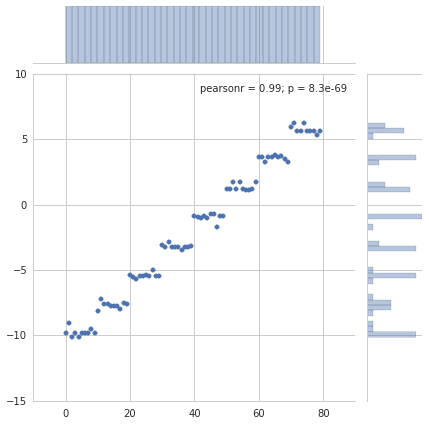

In [143]:
x_est = res['x_est'] 
#x_est = xinit
sns.jointplot(np.arange(N), x_est[:, 0], marginal_kws={'bins' : 40})

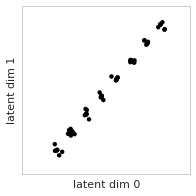

In [144]:
x_est = res['x_est'] 
#x_est = xinit
pylab.figure(figsize=(3,3))

pylab.scatter( x_est[:, 0], x_est[:, 1], c='k', 
              edgecolor='none') #  marginal_kws={'bins' : 40})
pylab.grid(False)

#pylab.xlim(-1, 1)
#pylab.ylim(-1, 1)
pylab.xticks([])
pylab.yticks([])
pylab.xlabel("latent dim 0")
pylab.ylabel("latent dim 1")

pylab.savefig("%s.foundlatent.pdf"% basename)

In [145]:
#kern_est = kern_f(x_est, theta_est )

#ke = kern_est[ai]
#ke = ke[:, ai]
#pylab.imshow(ke, interpolation='nearest', vmin=0, vmax=1)
#pylab.colorbar()

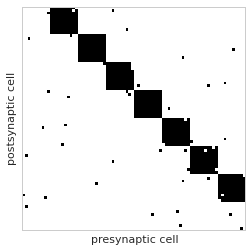

In [146]:

#theta = np.arctan2(x_est[:, 0], x_est[:, 1])
ai = np.argsort(-x_est[:, 0])
c = obs[ai]
c = c[:, ai]
pylab.imshow(c, interpolation='nearest')
pylab.grid(False)
pylab.grid(False)
pylab.xticks([])
pylab.yticks([])
pylab.xlabel("presynaptic cell")
pylab.ylabel("postsynaptic cell")
pylab.savefig("%s.foundsortedconn.pdf"% basename)


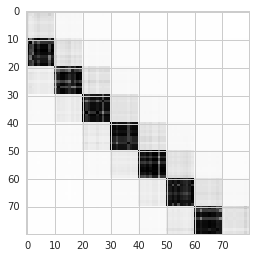

In [147]:
theta_est = res['theta_est']
est_params = kern_f(x_est, theta_est)
ep =est_params
fig = pylab.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)

ax.imshow(ep, interpolation='nearest', vmin=0, vmax=1)


In [148]:
### 
reload(sgd)
reload(exputil)

ITERS = 100000
print "D=", D
kfold_cv = 40
xinit = np.random.normal(0, 1.0, (N, D))
theta_init = np.ones(D)
t1 = time.time()
res = exputil.run_cv_exp_bfgs(kern_func, lossobj.cost(), 
               xinit, theta_init, obs, lossobj.obs_forward, kfold_cv, 
                iters=ITERS, theta_inference=True, svd_xinit=True, 
               verbose=False, verbose_iter=10)

print "total time", time.time() - t1
for ri, r in enumerate(res):
    fpr, tpr, th = sklearn.metrics.roc_curve(r['true_vals'],
                                             r['est_params'])

    pylab.plot(fpr, tpr, c='k', alpha=0.3)
pylab.legend(loc='lower right')

D= 2


ValueError: matrix type must be 'f', 'd', 'F', or 'D'

In [ ]:
for ri, r in enumerate(res):
    precision, recall, th = sklearn.metrics.precision_recall_curve(r['true_vals'],
                                                 r['est_params'])

    print sklearn.metrics.average_precision_score(r['true_vals'],
                                                     r['est_params'])
    pylab.plot(recall, precision, c='k', alpha=0.3, label=ri)
pylab.legend(loc='lower right')